In [1]:
import pandas as pd
import numpy as np

import glob

from typing import Union, List

import geopandas as gpd

import matplotlib.pyplot as plt
import os

In [2]:
idx = pd.IndexSlice

In [3]:
def read_wb_files(
    path: str,
    prefix: List[str],
    seg_id: Union[int, str],
    comment='!',
) -> pd.DataFrame:
    # get a list of files
    file_list = []
    for p in prefix:
        file_list += glob.glob(path+'/'+p+'*')

    # empty pandas.DataFrame for concatenation
    df = pd.DataFrame([])

    # loop through the `file_list` and read the seg_id's data
    for f in file_list:
        # extract the file name
        name = f.split('/')[-1].split('.')[0]

        # read the file into a temporary pandas.DataFrame
        temp_df = pd.read_csv(f, index_col=0, header=0, sep='\t', comment=comment)

        # `seg_id` column + name
        try:
            col = temp_df.loc[:, seg_id]
            col.name = name
            
            # concatenate results
            df = pd.concat([df, col], axis=1)
        except:
            print(f'{seg_id} is missing for `{name}` file!')

    # return df
    return df

In [4]:
def read_wbf_files(directory_path: str, prefix: str) -> pd.DataFrame:
    # Get a list of files with the specified prefix in the directory
    file_list = [os.path.join(directory_path, f) for f in os.listdir(directory_path) if f.startswith(prefix) and f.endswith('.txt')]

    # Initialize an empty pandas DataFrame for summation
    summed_df = None

    # Loop through the `file_list` and sum the data
    for f in file_list:
        # Read the file into a temporary pandas DataFrame
        temp_df = pd.read_csv(f, index_col=0, header=0, sep='\t')

        # Initialize the summed DataFrame if it's None
        if summed_df is None:
            summed_df = temp_df
        else:
            # Add the data from the current file to the existing summed DataFrame
            summed_df += temp_df

    # If no data was found, return an empty DataFrame
    if summed_df is None:
        return pd.DataFrame()

    # Save the headers of summed_df as the row index of total_df
    total_df = pd.DataFrame(summed_df.sum(axis=0), columns=["balance"])
    total_df.index.name = "Header"

    # Reset the index of summed_df
    summed_df.reset_index(inplace=True)

    return total_df

In [5]:

def read_wbs_files(
    file_path: str,
    summed_df: pd.DataFrame = None
) -> pd.DataFrame:
    # Read the file into a pandas DataFrame
    df = pd.read_csv(file_path, index_col=0, header=0, sep='\t')

    # Calculate the difference between the first and last row for each column
    row_difference = df.iloc[-1] - df.iloc[0]

    # Initialize the summed DataFrame if it's None
    if summed_df is None:
        summed_df = pd.DataFrame(index=row_difference.index)

    # Add the row difference to the existing summed DataFrame with the column name 'stor'
    summed_df['balance'] = row_difference.values

    return summed_df

In [6]:
def process_pobs(text_file_path):
    
    df = pd.read_csv(text_file_path, delimiter='\t', index_col=0)
    
    #trim to only the model time period
    df = df.iloc[0:13149]
    
        # Save the headers of summed_df as the row index of total_df
#    prec = pd.DataFrame(df.sum(), columns=["prec"])
 #   prec.index.name = "Header"
    
        # Create a DataFrame 'prec' with the sum of each column in 'df'
    prec = pd.DataFrame(df.sum(axis=0), columns=["prec"])
    prec.index.name = "Header"
    
    # Move the summed column values to the matching row index in 'prec'
    prec['prec'] = df.sum(axis=0).values
    
    return prec

In [7]:
def format_shapefile(shapefile_path, evap, prec):
    # Read the shapefile using GeoPandas
    gdf = gpd.read_file(shapefile_path)

    # Convert the "seg_nhm" column in the shapefile to string
    gdf["seg_nhm"] = gdf["seg_nhm"].astype(str)

    # Merge the shapefile with the "total_df" DataFrame based on the "seg_nhm" column
    merged_gdf = gdf.merge(evap, left_on="seg_nhm", right_index=True, how="left")
    
        # Merge the shapefile with the "total_df" DataFrame based on the "seg_nhm" column
    merged_gdf = merged_gdf.merge(prec, left_on="seg_nhm", right_index=True, how="left")
    
    #convert volume to depth by dividing by area
    merged_gdf["balance"] = merged_gdf["balance"] / merged_gdf["Shape_Area"]
      
    # convert m to mm
    merged_gdf["balance"] *= 1000
    
    # percent evaporated
    merged_gdf["%"]= merged_gdf["balance"] / merged_gdf["prec"]
    
        # Check if there are any numbers bigger than 1 in the "%" column
    if (merged_gdf["%"] > 1).any():
        print("Warning: There are values in the '%' column that are greater than 1.")


    return merged_gdf

In [8]:
def format_shapefile_wbs(shapefile_path, evap, prec):
    # Read the shapefile using GeoPandas
    gdf = gpd.read_file(shapefile_path)

    # Convert the "seg_nhm" column in the shapefile to string
    gdf["seg_nhm"] = gdf["seg_nhm"].astype(str)

    # Merge the shapefile with the "total_df" DataFrame based on the "seg_nhm" column
    merged_gdf = gdf.merge(evap, left_on="seg_nhm", right_index=True, how="left")
    
        # Merge the shapefile with the "total_df" DataFrame based on the "seg_nhm" column
    merged_gdf = merged_gdf.merge(prec, left_on="seg_nhm", right_index=True, how="left")
    
    # convert p to m3
    merged_gdf["prec"] = merged_gdf["prec"] * 0.001 * merged_gdf["Shape_Area"]
    
    # percent evaporated
    merged_gdf["%"]= merged_gdf["balance"] / merged_gdf["prec"]
    
        # Check if there are any numbers bigger than 1 in the "%" column
    if (merged_gdf["%"] > 1).any():
        print("Warning: There are values in the '%' column that are greater than 1.")


    return merged_gdf

In [9]:
def plot_shapefile_with_color(gdf, column_to_color='%'):
    """
    Plot a GeoDataFrame with varying colors based on a specified column.

    Args:
        gdf (gpd.GeoDataFrame): GeoDataFrame containing the data.
        column_to_color (str): Name of the column to determine colors.

    Returns:
        None
    """
    # Plot the GeoDataFrame with varying colors based on the specified column
    fig, ax = plt.subplots(figsize=(12, 8))
    gdf.plot(column=column_to_color, cmap='coolwarm', linewidth=0.8, ax=ax, legend=True)
    ax.set_title('Percentage of Rain')
    
    # Manually set axis labels for latitude and longitude
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')

    
    plt.show()

In [10]:
def full_basin(gdf):
    """
    Calculate the total precipitation, total evaporation, and the percentage of evaporation relative to precipitation.

    Args:
        gdf (gpd.GeoDataFrame): GeoDataFrame containing the data.

    Returns:
        pd.DataFrame: DataFrame containing total precipitation, total evaporation, and percentage.
    """
    # Sum the "prec" and "evap" columns
    total_precipitation = gdf["prec"].sum()
    total_evaporation = gdf["balance"].sum()
    
    # Calculate the percentage of evaporation relative to precipitation
    percentage = (total_evaporation / total_precipitation) * 100
    
    # Create a DataFrame to store the results
    result_df = pd.DataFrame({
        "Total Precipitation": [total_precipitation],
        "Total WB": [total_evaporation],
        "Percentage": [percentage]
    })
    
    return result_df

In [11]:
def individual_basin(gdf, seg_id):
    """
    Calculate the total precipitation, total evaporation, and the percentage of evaporation relative to precipitation.

    Args:
        gdf (gpd.GeoDataFrame): GeoDataFrame containing the data.
        seg_id (int) station ID to be studied containing the 

    Returns:
        pd.DataFrame: DataFrame containing total precipitation, total evaporation, and percentage.
    """
    # Convert the specified column to integers
    gdf['seg_nhm'] = gdf['seg_nhm'].astype(int)
    
    # Filter rows where seg_nhm matches the input seg_id
    filtered_data = gdf[gdf['seg_nhm'] == seg_id]
    
    # Extract values for specific columns from the first row of filtered data
    evap = filtered_data['balance'].values[0]  # Get the 'evap' value for the specified row
    prec = filtered_data['prec'].values[0]  # Get the 'prec' value for the specified row
    percentage = filtered_data['%'].values[0]  # Get the '%' value for the specified row
    
    # Convert to #
    percentage= percentage * 100
    
    # Create a DataFrame to store the results
    result_df = pd.DataFrame({
        "Precipitation for ID": [prec],
        "WB for ID": [evap],
        "Percentage": [percentage]
    })
    
    return result_df

In [12]:
path_result = '/home/paulc600/scratch/final_hype_setup/KGE_-0.28/data/'
shapefile_path= '/home/paulc600/local/SMM/Modified_HYPE/Modified_SMMcat.shp'
pobs='/home/paulc600/scratch/final_hype_setup/KGE_0.98/data/Pobs.txt'
seg = 58669

In [13]:
prec= process_pobs(pobs)

In [14]:
# read WBf
wb= read_wbf_files(path_result, 'WBf_evap')
# Evap: WBf_evap
# Flow: WBf_flow_lstream_mriver
# Snow: WBf_snowfall_snow
# Rain: WBf_rain

In [15]:
wb

,balance
Header,
58675,3.625976e+09
58674,3.234547e+09
58673,3.406813e+09
58672,1.178406e+10
58671,4.530680e+09
...,...
58185,7.748657e+07
58231,2.351606e+09
58184,2.387062e+08


In [16]:
wb_gdf = format_shapefile(shapefile_path, wb, prec)

In [17]:
# Filter rows where the '% ' column is greater than 1
filtered_rows = wb_gdf[wb_gdf['%'] > 1]

In [29]:
print(filtered_rows)

     hru_nhm seg_nhm        POI_ID  hru_id  hru_segmen  hru_id_tb  hru_segm_1  \
40    113656   58242  2.300280e+13      46           1       3705        1782   
41    113683   58243  2.300280e+13      73           2       3732        1783   
42    113696   58244  2.300280e+13      86           3       3745        1784   
43    113703   58245  2.300280e+13      93           4       3752        1785   
44    113680   58246  2.300280e+13      70           5       3729        1786   
..       ...     ...           ...     ...         ...        ...         ...   
460   114069   58663  2.300280e+13     459           0       4118           0   
462   114213   58665  2.300280e+13     603           0       4262           0   
463   114230   58666  2.300280e+13     620           0       4279           0   
471   114388   58674  2.300280e+13     778           0       4437           0   
472   114417   58675  2.300280e+13     807           0       4466           0   

     Type_NCA HUC04  Coasta

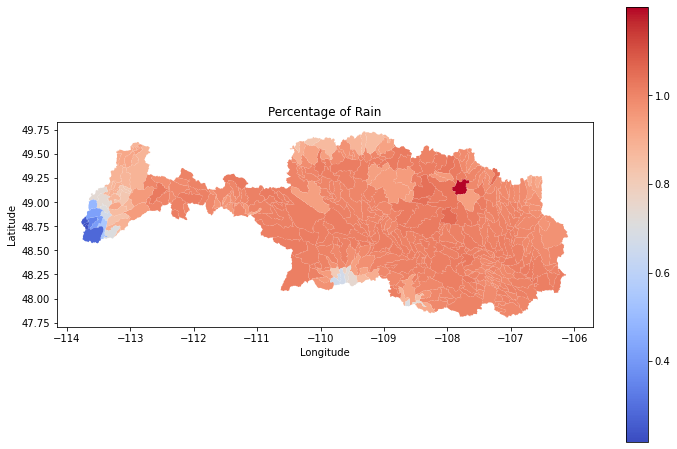

In [19]:
# Evap
plot_shapefile_with_color(wb_gdf, '%')

In [20]:
full_basin(wb_gdf)

,Total Precipitation,Total WB,Percentage
0,6.827754e+06,6.397866e+06,93.70381
